# <span style ='color:orange'>Imports

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import shap

%reload_ext autoreload
%autoreload 2

from data_boxscore.data import load_dataframes, custom_query_df
from data_boxscore.xai import shap_query
from data_boxscore.constants import  features_minmax, features_no_scaling, features_perc, features_robust, features_standard

# <span style ='color:blue'>Loading data

In [39]:
team = "Villeneuve d'Ascq LM"
league = None
season = None

excluded_columns = ['diff_score', 'league_id','gameday', 'game_id']

In [40]:
gdf, X_train, y_train, X_val, y_val, X_test, y_test, X_query, y_query = load_dataframes(filename='bball.csv',
                                                                    features_standard = features_standard, 
                                                                    features_minmax = features_minmax, 
                                                                    features_robust = features_robust, 
                                                                    features_perc = features_perc,
                                                                    features_no_scaling = features_no_scaling,              
                                                                    use_ELO = True,
                                                                    k_elo = 20,
                                                                    excluded_columns=excluded_columns,
                                                                    team=team,
                                                                    season=season,
                                                                    league=league)
print(gdf.shape, X_train.shape, X_val.shape ,X_test.shape, )
gdf['home_win'].mean()

(21, 57)
(840, 57) (504, 53) (126, 53) (126, 53)


0.6

In [41]:
gdf.head(5)

,away_team,home_team,A_score,H_score,A_FGM,H_FGM,A_FGA,H_FGA,A_FG%,H_FG%,...,H_efficiency,H_eFG%,A_eFG%,H_OREB%,A_OREB%,H_TOV%,A_TOV%,diff_score,home_win,ELO_diff_before
game_id,,,,,,,,,,,,,,,,,,,,,
0,CCC Polkowice,Pieštanské Cajky,71,46,24,14,54,49,0.444444,0.285714,...,41,0.326531,0.509259,0.216216,0.264706,0.236097,0.201918,-25,False,0.0
1,Pieštanské Cajky,CCC Polkowice,60,76,24,27,65,53,0.369231,0.509434,...,93,0.584906,0.407692,0.230769,0.300000,0.230651,0.180549,16,True,20.0
2,BLMA,KSC Szekszard,79,80,29,28,48,59,0.604167,0.474576,...,67,0.550847,0.625000,0.382353,0.363636,0.199437,0.227638,1,True,0.0
3,KSC Szekszard,BLMA,71,86,26,30,58,56,0.448276,0.535714,...,102,0.598214,0.534483,0.400000,0.322581,0.234632,0.242718,15,True,-20.0
4,Galatasaray,Sopron Basket,55,72,23,29,71,58,0.323944,0.500000,...,85,0.517241,0.345070,0.357143,0.224490,0.270880,0.165125,17,True,0.0


In [42]:
X_test = X_test[:10]
y_test = y_test[:10]
X_test.shape, y_test.shape

((10, 53), (10,))

# <span style ='color:green'>Models

In [43]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', probability=True, C = 50, gamma = 0.0005)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Model accuracy = {accuracy_score(y_pred, y_test)}")

Model accuracy = 1.0


# <span style ='color:lightgreen'>XAI

### Local

In [44]:
# creating SV object with all X_train in the background
shap_prob_explainer = shap.Explainer(model.predict_proba, X_train)
# Fitting on X_test
sv_prob = shap_prob_explainer(X_test)

Index max in test set : 10


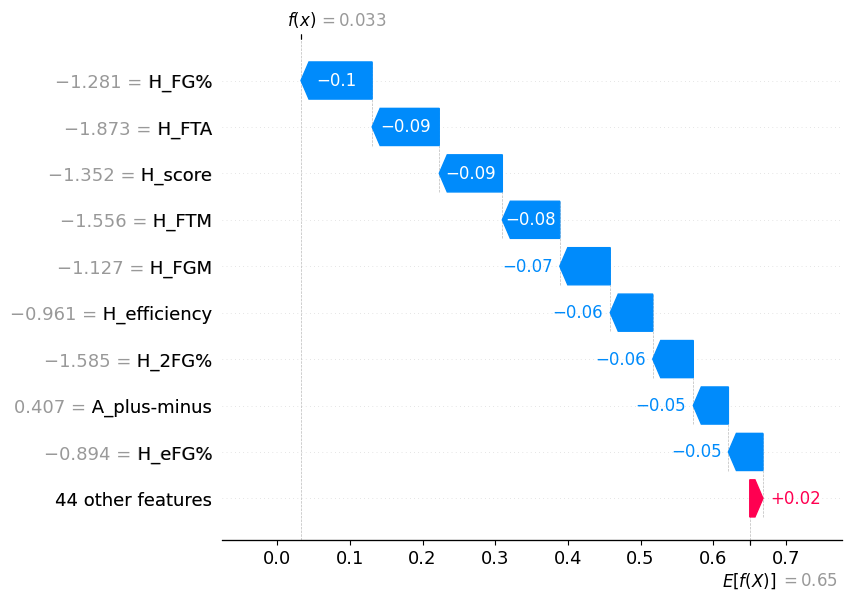

In [45]:
ind = 9

print(f"Index max in test set : {X_test.shape[0]}")
shap.plots.waterfall(sv_prob[ind,:,1])

### Global

In [46]:
# creating SV object with all X_train in the background
shap_pred_explainer = shap.Explainer(model.predict, X_train)
# Fitting on X_test
sv_pred = shap_pred_explainer(X_test)

<Axes: xlabel='SHAP value (impact on model output)'>

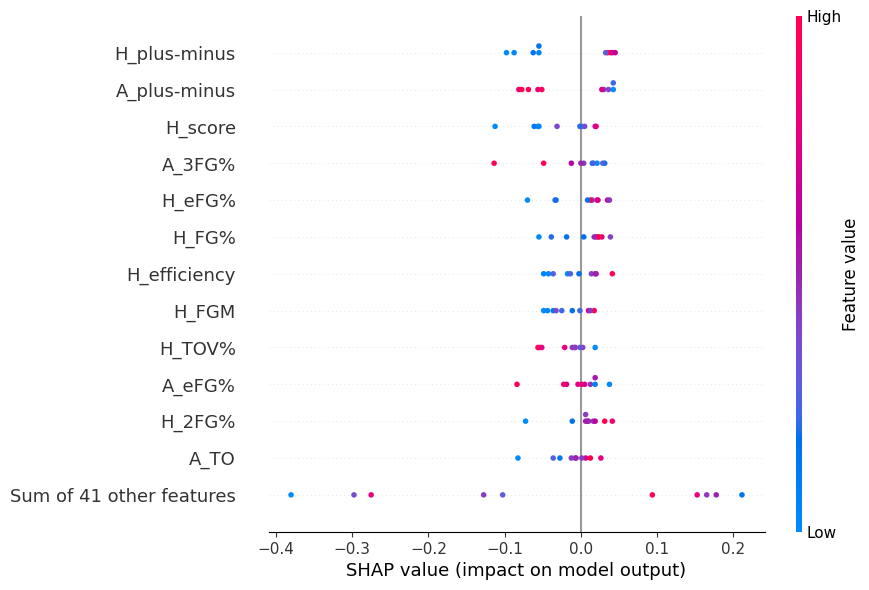

In [47]:
shap.plots.beeswarm(sv_pred, max_display=13, show=False)

### Query

In [48]:
X_query.shape

(21, 53)

In [50]:
shap_query_df = shap_query(df =gdf,
                           X_query = X_query,
                           shap_explainer= shap_prob_explainer,
                           team=team,
                           season = season,
                           league = league)
shap_query_df.head()

,home_team,away_team,A_score,H_score,A_FGM,H_FGM,A_FGA,H_FGA,A_FG%,H_FG%,...,H_plus-minus,A_efficiency,H_efficiency,H_eFG%,A_eFG%,H_OREB%,A_OREB%,H_TOV%,A_TOV%,ELO_diff_before
0,Villeneuve d'Ascq LM,Spar Girona,0.035968,0.007309,0.037273,0.008241,0.005123,0.000543,0.027324,0.024802,...,0.039365,0.011650,0.013047,0.016719,0.029860,-0.003648,0.006223,0.001231,0.011009,0.003618
1,Spar Girona,Villeneuve d'Ascq LM,0.045629,0.000499,0.026885,-0.010811,-0.000443,-0.005617,0.015753,0.008492,...,0.039734,0.026077,0.001587,0.010277,0.028744,-0.002860,0.007399,-0.008484,-0.002250,0.002503
2,Villeneuve d'Ascq LM,Serco UNI Gyor,-0.066071,0.119423,-0.037970,0.079821,-0.015329,0.009221,-0.015945,0.062297,...,0.009934,-0.039033,0.052176,0.064644,-0.041571,-0.003449,-0.001829,0.030077,0.012343,0.005751
3,Perfumerias Avenida,Villeneuve d'Ascq LM,0.010886,0.027885,0.013583,0.011436,0.002538,-0.004835,0.015350,0.035016,...,0.046039,0.022209,0.007737,0.029981,0.006021,-0.004067,0.006321,-0.006992,-0.001939,0.012068
4,Villeneuve d'Ascq LM,Cukurova Basketbol Mersin,-0.016964,-0.036486,0.003165,-0.018135,0.008549,-0.002944,-0.004308,-0.030953,...,-0.065191,-0.004725,-0.059273,-0.057804,-0.011152,-0.009257,0.009054,-0.000958,-0.010580,-0.005332


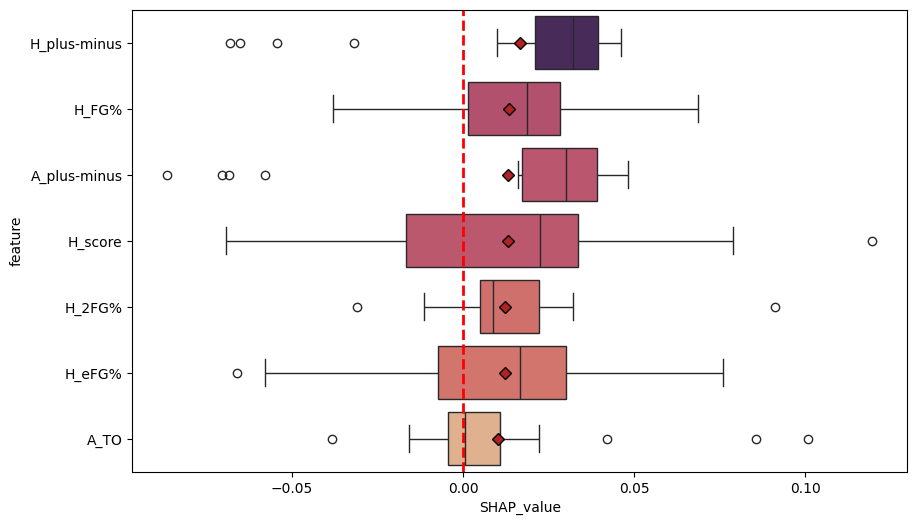

In [52]:
threshold = 0.01

fig, ax = plt.subplots(1,1,figsize = (10,6))
info_cols = ['game_id','home_team', 'away_team'] if 'game_id' in shap_query_df.columns else ['home_team', 'away_team']
team_expl_cols = shap_query_df.drop(columns = info_cols).columns
id = pd.MultiIndex.from_product([shap_query_df[team_expl_cols].index, shap_query_df[team_expl_cols].columns], names=('gameday', 'feature'))
t_df = pd.DataFrame(np.array(shap_query_df[team_expl_cols]).reshape(len(shap_query_df[team_expl_cols])*len(shap_query_df[team_expl_cols].columns),1), index = id).rename(columns={0:'SHAP_value'})
t_df.reset_index(inplace= True)
feat_mask = (t_df.groupby('feature').mean()['SHAP_value'].abs() > threshold).rename('Threshold_filter')
mean_shap = t_df.groupby('feature').mean()['SHAP_value'].rename('Mean_SHAP_value')
t_df = t_df.merge(feat_mask, left_on = 'feature', right_index = True)
t_df = t_df.merge(mean_shap, left_on = 'feature', right_index = True)
t_df.sort_values(by = 'Mean_SHAP_value', ascending = False, inplace=True)
meanpointprops = dict(marker='D', markeredgecolor='black',
                    markerfacecolor='firebrick')
sns.boxplot(data = t_df[t_df['Threshold_filter']], x = 'SHAP_value', y = 'feature', hue = 'Mean_SHAP_value', palette = 'flare', legend = False, ax=ax, showmeans = True, meanprops = meanpointprops)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.close()